# Búsqueda en juegos competitivos

Adaptado de Russell & Norvig (2016), cap. 5.

### Problemas de confrontación

En clase discutimos la propuesta de Alan Turing frente a la pregunta "¿Pueden pensar las máquinas?", según la cual debemos considerar que un computador piensa si logra ganar el *juego de la imitación*. El objetivo de fondo de este juego es que el computador debe demostrar un comportamiento que los humanos juzguamos como inteligente. 

Ahora bien, el juego de la imitiación puede reformularse de manera más sencilla y a la vez más convienientes para las máquinas, sobre todo aquellas que existían en la segunda mitad del siglo XX. Por ejemplo, un computador puede exhibir un comportamiento inteligente si tiene un buen desempeño en los juegos que los humanos juzgamos como desafiantes y que requieren (por lo menos una buena dosis) de inteligencia. Esta es una de las razones por las cuales el ajedrez computarizado fue tan relevante en los inicios de la IA. 

En este notebook veremos el problema de ganar un juego competitivo contra un humano como el desafío que debe superar una máquina y así, al hacerlo, exhibir una dosis de inteligencia.


### Objetivo

Estudiar algunas estrategias para la búsqueda de soluciones en juegos de dos jugadores. Estos escenarios son muy convenientes, toda vez que corresponden a entornos completamente observables, deterministas, discretos y conocidos. El desafío respecto al caso anterior es que ahora el entorno es dinámico, toda vez que este cambiará de acuerdo a las acciones del contrincante. 

### Secciones

Desarrollaremos la explicación de la siguiente manera:

1. Definición formal del problema de confrontación del triqui y su implementación en python.
2. Algoritmo minmax para resolver el triqui y su implementación en python.

### Juegos competitivos

La **definición formal** de un juego competitivo se hace con base en las siguientes características:

* **Estado inicial:** Situación del entorno desde el cual comienza el juego. En el caso del triqui, el estado inicial es el tablero vacío.

* **Jugador(s):** Define cuál jugador tiene el turno en el estado `s`, el cual puede ser `O` o `X`.

* **Posibles acciones(s):** Descripción de las posibles acciones del Jugador(`s`), dado un estado `s`. En este caso, poner o bien una `O` o bien una `X` en una casilla vacía.

* **Función de transiciones(s, a):** Descripción del entorno que resulta de la ejecución de la acción `a` por el `Jugador(s)` en el estado `s`. Junto con el estado inicial y las posibles acciones, la función de transiciones define el espacio de estados del juego.

* **Prueba de objetivo(s):** Permite determinar si el juego se termina cuando se obtiene el estado `s`. 

* **Función de utilidad(s):** Definida sólo para aquellos estados `s` en los cuales el juego se termina. Esta función establece la utilidad en `s`. En nuestro caso del triqui, asumiremos que si el ganador es el jugador de las $O$, la utilidad es -1; si el ganador es el jugador de las $X$, la utilidad es 1; y en caso de empate la utilidad es 0.

**Implementación en python**

Una posible implementación del juego del triqui en python es la siguiente.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from random import choice
import copy

%matplotlib inline

In [49]:
class triqui:
    
    def estado_inicial(self):
        return np.matrix([[0]*3]*3)
    
    def pintar_estado(self, estado):
        # Dibuja el tablero correspondiente al estado
        # Input: estado, que es una 3-lista de 3-listas
        fig, axes = plt.subplots()

        # Dibujo el tablero
        step = 1./3
        offset = 0.001
        tangulos = []

        # Borde del tablero
        tangulos.append(patches.Rectangle((0,0),0.998,0.998,\
                                          facecolor='cornsilk',\
                                         edgecolor='black',\
                                         linewidth=2))

        # Creo las líneas del tablero
        for j in range(3):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, locacion), 1, 0.008],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(locacion, 0), 0.008, 1],\
                    facecolor='black'))

        for t in tangulos:
            axes.add_patch(t)

        # Cargando imagen de O
        arr_img_O = plt.imread("./imagenes/O.png", format='png')
        image_O = OffsetImage(arr_img_O, zoom=0.14)
        image_O.image.axes = axes

        # Cargando imagen de X
        arr_img_X = plt.imread("./imagenes/X.png", format='png')
        image_X = OffsetImage(arr_img_X, zoom=0.14)
        image_X.image.axes = axes

        offsetX = 0.15
        offsetY = 0.15

        # ASUMO QUE LAS O SE REPRESENTAN CON 1 EN LA MATRIZ
        # Y QUE LAS X SE REPRESENTAN CON 2
        for i in range(3):
            for j in range(3):
                if estado[j, i] == 1:
                    # print("O en (" + str(i) + ", " + str(j) + ")")
                    Y = 2 - j
                    X = i
                    # print("(" + str(X) + ", " + str(Y) + ")")
                    ab = AnnotationBbox(
                        image_O, 
                        [(X*step) + offsetX, (Y*step) + offsetY], 
                        frameon=False)
                    axes.add_artist(ab)
                if estado[j, i] == 2:
                    # print("X en (" + str(i) + ", " + str(j) + ")")
                    Y = 2 - j
                    X = i
                    # print("(" + str(X) + ", " + str(Y) + ")")
                    ab = AnnotationBbox(
                        image_X, 
                        [(X*step) + offsetX, (Y*step) + offsetY], 
                        frameon=False)
                    axes.add_artist(ab)
        
        axes.axis('off')
        return axes
    
    def jugador(self, estado):
        # Devuelve el número del jugador a quien corresponde el turno
        # 1 para las O
        # 2 para las X
        num_Os = np.count_nonzero(estado==1)
        num_Xs = np.count_nonzero(estado==2)
        # print("Cantidad O:", num_Os, " Cantidad X:", num_Xs)
        if num_Os < num_Xs:
            return 1
        else:
            return 2
    
    def acciones_aplicables(self, estado):
        # Devuelve una lista de parejas que representan las casillas vacías
        # Input: estado, que es una np.matrix(3x3)
        # Output: lista de índices (x,y)
        indices = [(x, y) for x in range(3) for y in range(3)]
        indices_bloqueados = []
        # Chequeamos primero que haya menos de ocho reinas
        if estado.sum() >= 3:
            return []
        else:
            # Bloqueamos índices por cada reina encontrada
            for x in range(3):
                for y in range(3):
                    if estado[y, x]==1:
                        #print("Reina encontrada en", x, y)
                        # Encuentra una reina
                        # Elimina la fila
                        #print("Bloqueando filas...")
                        indices_bloqueados += [(i, y) for i in range(3)]
                        # Elimina la columna
                        #print("Bloqueando columnas...")
                        indices_bloqueados += [(x, i) for i in range(3)]
                        # Elimina las diagonales \
                        # print("\nBloqueando diagonales...")
                        dif = np.abs(x-y)
                        offset_x = 0
                        offset_y = 0
                        for i in range(1, 3 - dif):
                            if (y + i) == 3:
                                offset_x = - (x + i)
                                offset_y = dif
                            if (x + i) == 3:
                                offset_x = dif
                                offset_y = - (y + i)
                            xB = (x + i + offset_x) % 3
                            yB = (y + i + offset_y) % 3
                            # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                            indices_bloqueados.append((xB, yB))
                        # Elimina las transversales /
                        # print("\nBloqueando transversales...")
                        dif1 = np.abs((2-x)-y)
                        # print("\n Dif", dif1)
                        offset_x = 0
                        offset_y = 0
                        for i in range(1, 3 - dif1):
                            xB = (x + i + offset_x) % 3
                            yB = (y - i + offset_y) % 3
                            # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                            indices_bloqueados.append((xB, yB))
                            if yB == 0:
                                offset_x = - (x + i + 1)
                                offset_y = x + i + 1
                            if xB == 2:
                                offset_x = y - (i + 1) - 2
                                offset_y = 2 - (y - i)

            return list(set(indices) - set(indices_bloqueados))

    def transicion(self, estado, indice):
        # Devuelve el tablero incluyendo una O o X en el indice,
        # dependiendo del jugador que tiene el turno
        # Input: estado, que es una np.matrix(3x3)
        #        indice, de la forma (x,y)
        # Output: estado, que es una np.matrix(3x3)  
        ficha = self.jugador(estado)
        s = copy.deepcopy(estado)
        x = indice[0]
        y = indice[1]
        s[y, x] = ficha #Devuelve una O
        return s
    
    def test_objetivo(self, estado):
        # Devuelve True/False dependiendo si el juego se acabó
        # Input: estado, que es una np.matrix(3x3)
        # Output: True/False
        # print("Determinando si no hay casillas vacías...")
        casillas_disp = estado.sum()
        print("casillas disp:",casillas_disp)
        if casillas_disp != 3:
            # print("Numero incorrecto de reinas!")
            return False
        else:
            # print("Determinando si las reinas no se atacan...")
            # print("Buscando reina por fila...")
            filas = [i[0] for i in estado.sum(axis=1).tolist()]
            if any(i>1 for i in filas):
                # print("Dos reinas en la misma fila!")
                return False
            else:
                # print("Buscando reina por columna...")
                columnas = estado.sum(axis=0).tolist()[0]
                if any(j>1 for j in columnas):
                    # print("Dos reinas en la misma columna!")
                    return False
                else:
                    for x in range(3):
                        for y in range(3):
                            if estado[y, x]==1:
                                # print("Reina encontrada en (" + str(x) + ", " + str(y) + ")")
                                # print("Buscando otra reina en la misma diagonal...")
                                dif = np.abs(x-y)
                                offset_x = 0
                                offset_y = 0
                                for i in range(1, 3 - dif):
                                    if (y + i) == 3:
                                        offset_x = - (x + i)
                                        offset_y = dif
                                    if (x + i) == 3:
                                        offset_x = dif
                                        offset_y = - (y + i)
                                    xB = (x + i + offset_x) % 3
                                    yB = (y + i + offset_y) % 3
                                    if estado[yB, xB] == 1:
                                        #print("Dos reinas en la misma diagonal!")
                                        return False
            
                                # print("Buscando otra reina en la misma transversal...")
                                dif1 = np.abs((2-x)-y)
                                # print("\n Dif", dif1)
                                offset_x = 0
                                offset_y = 0
                                for i in range(1, 3 - dif1):
                                    xB = (x + i + offset_x) % 3
                                    yB = (y - i + offset_y) % 3
                                    # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                                    if estado[yB, xB]==1:
                                        # print("Dos reinas en la misma transversal!")
                                        return False
                                    if yB == 0:
                                        offset_x = - (x + i + 1)
                                        offset_y = x + i + 1
                                    if xB == 2:
                                        offset_x = y - (i + 1) - 2
                                        offset_y = 3 - (y - i)
                                        
        return True 
        pass

    def utilidad(self, estado):
        # Devuelve la utilidad del estado donde termina el juego
        # Input: estado, que es una np.matrix(3x3)
        # Output: utilidad, que es un valor -1, 0, 1
        final = self.acciones_aplicables(estado)
        utilidad1=None
        if len(final)==0:
                if estado.sum()>0:
                    utilidad1 = 1
                elif estado.sum()<0:
                    utilidad1 = -1
                else:
                    utilidad1 = 0
                                    
        return utilidad1

**Ejercicio 1:** 

Implemente los métodos `acciones_aplicables`, `transicion`, `test_objetivo`, y `utilidad` para la clase `triqui`. Compruebe el funcionamiento de su implementación corriendo la siguiente celda:

[[0 0 0]
 [0 0 0]
 [0 0 0]]
(1, 1)
Este es el tablero con una X en (1, 1)
[[0 0 0]
 [0 2 0]
 [0 0 0]]
casillas disp: 2
Juego terminado?: False
Utilidad: None


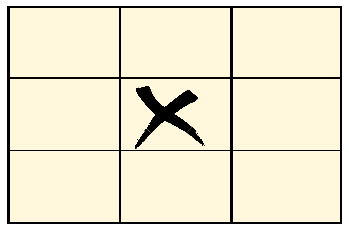

In [50]:
T = triqui()
s = T.estado_inicial()
print(s)
a = choice(T.acciones_aplicables(s))
print(a)
print("Este es el tablero con una X en", a)
s1 = T.transicion(s, a)
print(s1)
T.pintar_estado(s1)
print("Juego terminado?:", T.test_objetivo(s1))
print("Utilidad:", T.utilidad(s1))

Este es el tablero con una X en [(0, 1), (1, 2), (0, 0), (2, 1), (2, 0), (1, 1), (2, 2), (1, 0), (0, 2)]
Juego terminado?: False
Utilidad: None


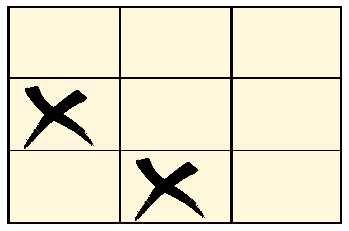

In [27]:
T = triqui()
s = T.estado_inicial()
a = T.acciones_aplicables(s)
print("Este es el tablero con una X en", a)
s1 = T.transicion(s, a)
T.pintar_estado(s1)
print("Juego terminado?:", T.test_objetivo(s1)) # Debe ser None
print("Utilidad:", T.utilidad(s1)) # Debe ser None

---

### Árbol de confrontación

Debemos ahora definir un programa para el agente que juega triqui. Este programa debe consistir, de manera general, en una función que percibe un tablero de triqui y devuelve una acción. Más concretamente, el agente recibe un estado `s` y devuelve un índice `(x,y)`, el el cual ha de ponerse el símbolo correspondiente (o bien $O$ o bien $X$). 

El algoritmo que utilizaremos para definir el programa se llama *minmax*. Este nombre es muy acertado. Evoca a la vez la confrontación entre los jugadores así como la manera como se representa dicha confrontación. Esto es, un jugador buscará el mínimo y el otro el máximo de la utilidad. Esta es la razón por la cual se definió la función de utilidad de tal manera que un estado en el que gane el jugador de las $O$ vale -1 y uno en que gane el jugador de las $X$ vale 1. El primero será el jugador `min` y el segundo el `max`.

Dado un estado `s`, se define un árbol de confrontación para `s` de la siguiente manera. Se consideran todas las acciones aplicables de `Jugador(s)`, y para cada una de ellas se encuentra el correspondiente estado `s`$_i$. Luego, para cada uno de estos, se consideran todas las acciones aplicables de `Jugador(s`$_i$`)` y se encuentran los correspondientes estados. Así hasta llegar a los estados en los cuales el juego se termina.

Ahora debemos considerar cómo se obtienen los valores minmax a partir de la utilidad asignada a los estados en los cuales el juego se termina. También debemos entender cómo funciona la toma de decisiones una vez construido el árbol con los respectivos valores minmax en cada nodo. Explicaremos primero esto último, con base en el siguiente ejemplo:

<img src="imagenes/ejemplo-minmax.png" width="550px">

Supongamos dado el árbol de confrontación anterior, construido a partir del estado que se encuentra en la raíz. Este árbol se construye para decidir qué acción tomar cuando el turno le corresponde a `max`, es decir, el jugador de las $X$. Este debe seleccionar la opción que le reporte el máximo de los valores minmax de sus hijos. En este caso, debe seleccionar la única opción con valor 0. Observe que, si seleccionara cualquier otra opción (las cuales tienen valor $-1$), entonces `min` ganaría (esto es, suponiendo que `min` juega de la mejor manera posible).

Volviendo a la explicación, `max` selecciona la opción de más a la derecha, en la que bloquea el triqui de $O$. Consideremos ahora el juego desde el punto de vista de $O$. En este turno el jugador $O$ debe seleccionar la opción con menor valor minmax, en este caso, la opción con valor 0. Si fuera a seleccionar la opción con valor 1, entonces las $X$ ganarían.

### Algoritmo minmax

El siguiente es el pseudo código del algoritmo de decisión minmax, el cual genera, mediante una metodología deep-first, el árbol de confrontación para un estado dado `s` en el cual le corresponde el turno a `max`:

<img src="imagenes/busqueda-minmax.png" width="400px">

**Ejercicio 2:**

Implemente la función `minimax_decision`.

In [ ]:
class nodo:
    
    # Clase para crear los nodos
    
    def __init__(self, estado, madre, accion, costo):
        self.estado = estado
        self.madre = madre
        self.accion = accion
        self.costo = costo
        
def nodo_hijo(problema, madre, accion):
    
    # Función para crear un nuevo nodo
    # Input: problema, que es un objeto de clase ocho_reinas
    #        madre, que es un nodo,
    #        accion, que es una acción que da lugar al estado del nuevo nodo
    # Output: nodo

    return nodo(problema.transicion(madre.estado, accion),
                madre,
                accion,
                costo = madre.costo + problema.costo(madre.estado, accion)
               )

In [1]:
# AQUI CODIGO
def max_value(problema,estado):
    if(problema.test_objetivo(estado)):
        problema.utilidad(estado)
    acciones = problema.acciones_disponibles(estado)
    v = None
    for i in range(len(acciones)):
        a = acciones[i]
        v = max(v,min_value(problema.transicion(estado,a)))

def min_value(problema,estado):
    if(problema.test_objetivo(estado)):
        problema.utilidad(estado)
    acciones = problema.acciones_disponibles(estado)
    v = None
    for i in range(len(acciones)):
        a = acciones[i]
        v = max(v,min_value(problema.transicion(estado,a)))

Compruebe su código con los siguientes tableros:

In [ ]:
# Primer tablero de prueba
s1 = T.transicion(s, (1,1))
s1 = T.transicion(s1, (0,1))
s1 = T.transicion(s1, (2,1))
s1 = T.transicion(s1, (2,2))
s1 = T.transicion(s1, (1,0))
s1 = T.transicion(s1, (2,0))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (1, 2)

In [ ]:
# Segundo tablero de prueba
s1 = T.transicion(s, (2,1))
s1 = T.transicion(s1, (0,1))
s1 = T.transicion(s1, (1,2))
s1 = T.transicion(s1, (1,0))
s1 = T.transicion(s1, (1,1))
s1 = T.transicion(s1, (0,2))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (0, 0)

In [ ]:
# Tercer tablero de prueba
s1 = T.transicion(s, (1,1))
s1 = T.transicion(s1, (0,1))
s1 = T.transicion(s1, (0,0))
s1 = T.transicion(s1, (2,2))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (1, 0) o (2, 0)

---

**Ejercicio 3:**

Adapte el código de `minimax_decision` para que pueda tomar una decisión cuando le corresponda el turno a cualquiera de los dos jugadores.

In [32]:
# AQUI CODIGO

Verifique su implementación con los siguientes tableros:

In [ ]:
# Cuarto tablero de prueba
s1 = T.transicion(s, (2,1))
s1 = T.transicion(s1, (1,1))
s1 = T.transicion(s1, (1,2))
s1 = T.transicion(s1, (0,2))
s1 = T.transicion(s1, (0,0))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (2, 0)

In [ ]:
# Quinto tablero de prueba
s1 = T.transicion(s, (1,1))
s1 = T.transicion(s1, (0,0))
s1 = T.transicion(s1, (2,2))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (0, 2)

In [ ]:
# Sexto tablero de prueba
s1 = T.transicion(s, (2,0))
s1 = T.transicion(s1, (1,1))
s1 = T.transicion(s1, (2,2))
s1 = T.transicion(s1, (2,1))
s1 = T.transicion(s1, (0,1))
s1 = T.transicion(s1, (0,0))
s1 = T.transicion(s1, (0,2))
T.pintar_estado(s1)
print("Computador juega en:", minimax_decision(T, s1)) # Debe ser (1, 2)

---

**Ejercicio 4:**

Leer la sección 5.3 del libro de texto en la cual se explica el algoritmo alpha-beta pruning.

---

**Ejercicio 5:**

Leer la sección 5.4 del libro de texto en la cual se explican las técnicas de decisión imperfecta basadas en funciones de evaluación, cutting off y forward pruning.

---